<a href="https://colab.research.google.com/github/AinaRB/2022_TempReconstructionSaoPaulo_EO_ML/blob/main/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPATIAL CROSS VALIDATION

In [16]:
#IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from glob import glob
import io

### Load data and explore

In [15]:
#Import the data
from google.colab import files
uploaded = files.upload()


Saving data2018_modelinput.csv to data2018_modelinput.csv


In [17]:
df=pd.read_csv(io.BytesIO(uploaded['data2018_modelinput.csv']))

Below, we explore the dataframe:

In [18]:
df.head()

,station_code,date,lat,lon,source,year,month,day.x,temp_mean75,doy,...,elevation_500m,slope_500m,ImprSuf_SP,dist_to_coast,ESArivers,popdens,ndvi,bsa,sza,lst
0,1000840,2018-01-01,-23.63,-46.58,cgs_stations,2018,1,1,24.326035,1,...,743.772278,0.684851,2,45.233009,1.509531,10224.246094,0.173255,141.360397,1668,29.140158
1,1000840,2018-01-02,-23.63,-46.58,cgs_stations,2018,1,2,24.526826,2,...,743.772278,0.684851,2,45.233009,1.509531,10224.246094,0.173255,141.360397,1668,29.160706
2,1000840,2018-01-03,-23.63,-46.58,cgs_stations,2018,1,3,21.867257,3,...,743.772278,0.684851,2,45.233009,1.509531,10224.246094,0.173255,141.360397,1668,28.434814
3,1000840,2018-01-04,-23.63,-46.58,cgs_stations,2018,1,4,21.616583,4,...,743.772278,0.684851,2,45.233009,1.509531,10224.246094,0.173255,141.360397,1668,28.685966
4,1000840,2018-01-05,-23.63,-46.58,cgs_stations,2018,1,5,21.909021,5,...,743.772278,0.684851,2,45.233009,1.509531,10224.246094,0.173255,141.360397,1668,28.808559


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18615 entries, 0 to 18614
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_code    18615 non-null  object 
 1   date            18615 non-null  object 
 2   lat             18615 non-null  float64
 3   lon             18615 non-null  float64
 4   source          18615 non-null  object 
 5   year            18615 non-null  int64  
 6   month           18615 non-null  int64  
 7   day.x           18615 non-null  int64  
 8   temp_mean75     18316 non-null  float64
 9   doy             18615 non-null  int64  
 10  daylength       18615 non-null  float64
 11  X               18615 non-null  int64  
 12  day.y           18615 non-null  int64  
 13  elevation_500m  18615 non-null  float64
 14  slope_500m      18615 non-null  float64
 15  ImprSuf_SP      18615 non-null  int64  
 16  dist_to_coast   18615 non-null  float64
 17  ESArivers       18615 non-null 

In [20]:
#Clean dataset
df_c=df.dropna()
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16978 entries, 0 to 18614
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_code    16978 non-null  object 
 1   date            16978 non-null  object 
 2   lat             16978 non-null  float64
 3   lon             16978 non-null  float64
 4   source          16978 non-null  object 
 5   year            16978 non-null  int64  
 6   month           16978 non-null  int64  
 7   day.x           16978 non-null  int64  
 8   temp_mean75     16978 non-null  float64
 9   doy             16978 non-null  int64  
 10  daylength       16978 non-null  float64
 11  X               16978 non-null  int64  
 12  day.y           16978 non-null  int64  
 13  elevation_500m  16978 non-null  float64
 14  slope_500m      16978 non-null  float64
 15  ImprSuf_SP      16978 non-null  int64  
 16  dist_to_coast   16978 non-null  float64
 17  ESArivers       16978 non-null 

# 2. DEFINE CV PARAMETERS


In [21]:
import scipy as sp
from sklearn.cluster import KMeans

In [44]:
#K-means clustering
kmeans=KMeans(init="random",
              n_clusters=8, 
              n_init=10,
              max_iter=100)

In [31]:
#define features
x=df_c.iloc[:,2:4]
x

,lat,lon
0,-23.63,-46.58
1,-23.63,-46.58
2,-23.63,-46.58
3,-23.63,-46.58
4,-23.63,-46.58
...,...,...
18610,-23.65,-46.62
18611,-23.65,-46.62
18612,-23.65,-46.62
18613,-23.65,-46.62


### Selecting the most optimal numebr of clusters
In order to select the most optimal number of cluster we will use two indicaotrs or tools: 

a) The elbow plot which shows the wihtin cluster sum square value associated to each number of clusters used. The lowest the better. The optima lnumber of clusters is defined by the inflexion point in the curve or elbow.

b) Visual interpretation of the spatial distribution of clusters. For this we will use maps and critical interpretation. The above method runs the risk of favouring a high number of clusters, speacially if the point location are not too close to each other. Here we aim to check that we are not basically creating clusters with too few observations.

Text(0, 0.5, 'WCSS')

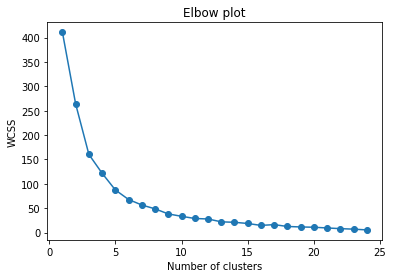

In [53]:
## The Elbow plot and the 'within-Cluster Sum of Square (wcss)'
wcss=[] 
for i in range(1,25):
  kmeans = KMeans(init="random",
              n_clusters=i, 
              n_init=10,
              max_iter=100)
  kmeans.fit(x)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)
  number_clusters = range(1,25)
plt.plot(number_clusters,wcss, marker='o')
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Based on the Elbow plot we define the most optimal number of cluster would be over 5 (where the WCSS starts to reduce and plateau). We will explore the spatial distribution of such plots

In [ ]:
# (b) Spatial visualization of the clusters
for i in range(5,15):
  kmeans = KMeans(init="random",
              n_clusters=i, 
              n_init=10,
              max_iter=100)
  kmeans.fit(x)
  identified_clusters = kmeans.fit_predict(x)
  data_with_clusters = df_c.copy()
  data_with_clusters['Clusters'] = identified_clusters 
  plt.figure()
  plt.scatter(data_with_clusters['lon'],data_with_clusters['lat'],c=data_with_clusters['Clusters'], cmap='rainbow')

Based on the assessment from the Elbow methdod (a) and the spatial plots (b), it seems like 8 clustesr is an optimal number. We will therefore use this numebr for our analyses.

In [ ]:
#Define the fnal number of clusters
nc=8
kmeans=KMeans(init="random",
              n_clusters=nc, 
              n_init="k-means++",
              max_iter=100)
